In [6]:
!pip install yfinance hmmlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.1 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


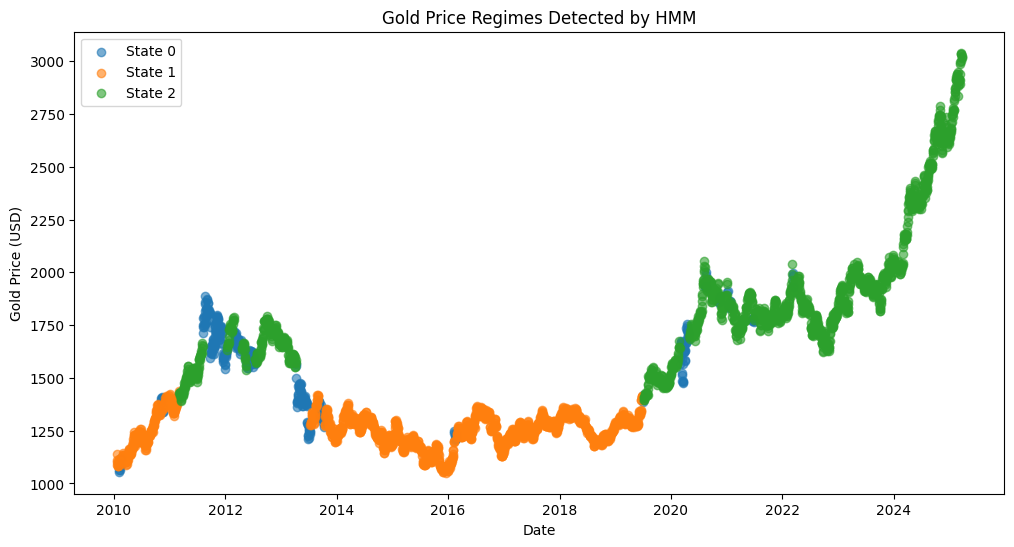

Predicted Future States: [1 1 1 1 1 1 1 1 1 1]


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from datetime import datetime, timedelta

# Step 1: Download Historical Gold Prices
symbol = "GC=F"  # Gold futures symbol on Yahoo Finance
start_date = "2010-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

gold_data = yf.download(symbol, start=start_date, end=end_date)

# Step 2: Data Preprocessing
if 'Adj Close' in gold_data.columns:
    gold_data["Returns"] = np.log(gold_data["Adj Close"] / gold_data["Adj Close"].shift(1))
else:
    gold_data["Returns"] = np.log(gold_data["Close"] / gold_data["Close"].shift(1))
    # If 'Adj Close' is not available, use 'Close' for other calculations as well
    # Replace 'Adj Close' with 'Close' in subsequent code
    gold_data.rename(columns={'Close': 'Adj Close'}, inplace=True)

# Step 3: Feature Engineering
# Using Returns, Moving Average, and Volatility
gold_data["SMA_10"] = gold_data["Adj Close"].rolling(window=10).mean()
gold_data["Volatility"] = gold_data["Returns"].rolling(window=10).std()

# Drop NaN values after feature creation
gold_data.dropna(inplace=True)

# Step 4: Prepare Data for HMM Training
X = gold_data[["Returns", "SMA_10", "Volatility"]].values

# Step 5: Train the Hidden Markov Model
n_states = 3  # Defining three hidden market states (Bull, Bear, Neutral)
hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000)
hmm_model.fit(X)

# Step 6: Predict Market States
hidden_states = hmm_model.predict(X)

# Step 7: Visualization of Hidden States
plt.figure(figsize=(12, 6))
for i in range(n_states):
    state = gold_data[hidden_states == i]
    plt.scatter(state.index, state["Adj Close"], label=f"State {i}", alpha=0.6)

plt.title("Gold Price Regimes Detected by HMM")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.show()

# Step 8: Predict Future State Probabilities
future_steps = 10
_, future_states = hmm_model.sample(future_steps)

print("Predicted Future States:", future_states)
